# Case Analysis including actions

This Covid explainer will walk you through how to run the MDP Algorithm on the code (in the version used by `covid_team2`). Everything you need to run the code should already be here in this folder, as the MDP algorithm was modified for Covid specifically. Relevant files in this directory include: 
* `mdp_model.py`
* `mdp_clustering.py`
* `mdp_testing.py`
* `mdp_tools.py`
* `states_combined_data.csv`**

** Note: some rows or columns have been taken out to create this sample dataset, to accomodate missing data in the original dataset. 

## Creating Training Data

We will run one round of the demonstration that trains on data that ends at a date earlier than the last date we have on our dataset. This way we can compare how well our model predicts to the real value in our data. The last date in this `states_combined_data.csv` contains up to `5/29/20`. 

In [1]:
# Load Built-in Modules
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle

# Ignore Python package warnings (not verbose)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# paths
DIRECTORY_PATH = os.path.dirname(os.getcwd())
os.chdir(DIRECTORY_PATH)

DATA_PATH   = os.path.join(os.getcwd(), "data", "input")
RESULT_PATH = os.path.join(os.path.dirname(os.getcwd()), "results")
MODEL_PATH  = os.path.join(os.getcwd(), "models")

In [3]:
# experiment name
EXPERIMENT_FOLDER = "01 - Cross-validation by state"  # not used for now
try: 
    assert os.path.exists(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))
except AssertionError:
    os.mkdir(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))

In [4]:
# Load MDP packages
import codes.mdp_model as mdp
from codes.mdp_testing import mape, plot_pred, plot_pred_action, plot_pred_fact
from codes.mdp_states_functions import createSamples
# from codes.utils import run_script # for multiprocessing

In [5]:
MODEL_PATH

'C:\\Users\\david\\Desktop\\MIT\\Courses\\Research internship\\covid19_team2\\models'

In [6]:
file = '07_08_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))
df.head()

Unnamed: 0    state        date  cases  deaths  population  emergdec  \
0           0  Alabama  2020-01-22      0       0   4903185.0         0   
1           1  Alabama  2020-01-23      0       0   4903185.0         0   
2           2  Alabama  2020-01-24      0       0   4903185.0         0   
3           3  Alabama  2020-01-25      0       0   4903185.0         0   
4           4  Alabama  2020-01-26      0       0   4903185.0         0   

   schoolclose  barrestrict  gathrestrict25  ...  workplaces  residential  \
0            0            0               0  ...         NaN          NaN   
1            0            0               0  ...         NaN          NaN   
2            0            0               0  ...         NaN          NaN   
3            0            0               0  ...         NaN          NaN   
4            0            0               0  ...         NaN          NaN   

   recovered  active  incident_rate  people_tested  people_hospitalized  \
0        NaN     NaN            NaN            NaN                  NaN   
1        NaN     NaN            NaN            NaN                  NaN   
2        NaN     NaN            NaN            NaN                  NaN   
3        NaN     NaN            NaN            NaN                  NaN   
4        NaN     NaN            NaN            NaN                  NaN   

   mortality_rate  testing_rate  hospitalization_rate  
0             NaN           NaN                   NaN  
1             NaN           NaN                   NaN  
2             NaN           NaN                   NaN  
3             NaN           NaN                   NaN  
4             NaN           NaN                   NaN  

[5 rows x 44 columns]

We can specify a value `n_days` to create a training dataset that ends `n_days` before this last date. We will also need to give the name of the date column from our `df`. 

## Import fitted model

Now that we understand how the samples are actually created, we can fit the samples to the model! Here, there are a few additional parameters that need to be set: 

`h` is the time horizon (in number of datapoints) that we take when calculating error. Essentially, we will be calculating the error of the most recent `h` points from the end. The goal of the algorithm is to minimize `testing_error`, so `testing_error` for a sequence of `h=1` points will be much smaller than for `h=5` points. If we are doing a 2 week prediction (`n_days = 14`), `h=5` while `d_avg=3` means that 5 datapoints correspond to a 15 day timespan, which means the algorithm will be minimizing error for around a 2 week period before the last date in the training data. If we take `h=-1`, the algorithm will try to minimize error over all the datapoints available in the training data.

`n_iter` is the maximum number of clusters we want the algorithm to stop at while training. Initial clustering is done using `clustering='Agglomerative'`, with a `distance_threshold = 0.1`, based on `RISK`. The algorithm will then split the cluster that contains the most contradictions (two points in the cluster taking the same action but ending up in different clusters), so one cluster becomes two. For points in the same cluster that don't take the action causing the contradiction, the group they enter is decided by `classification = 'DecisionTreeClassifier'`, which learns which group they are closer to based on their features. Splitting will stop when `n_iter` number of total clusters is reached.

`th` is the splitting threshold, which basically allows the split to happen if the number of points in contradiction within a cluster is greater than this `th` value. 

`model.fit` will also automatically run cross validation by splitting the dataset randomly into `cv=5` combinations of testing & training, where each `ID` (state) will be in the testing set exactly once. After cross validation, it will find the number of clusters that gives the smallest `testing_error`, and split the entire dataset once more to this exact number of clusters. Now let's run it!

In [32]:
# # Setting parameters
n_days = 15
date_col = 'date'
target_colname = 'cases'
region_colname = 'fips'
date_colname = 'date'
days_avg = 3

# model names deaths with actions
# model_name = "mdp_timecv150_DT_h8_10pct_cases_w_act.pickle"

In [46]:
# with open(r'C:\Users\david\Desktop\MIT\Courses\Research internship\results\12 - 20200723 UPDATED ERROR COMPUTATION\MDPs_with_actions\mdp_cases_w_act.pickle', 'rb') as filehandler:
#     m = pickle.load(filehandler)  ## best so far

with open(r'C:\Users\david\Desktop\MIT\Courses\Research internship\results\15 - 20200803 TEST ERROR COMPUTATION EXPONENTIAL TESTING\MDPs_without_actions\mdp_20200615_cases_state.pickle', 'rb') as filehandler:
    m = pickle.load(filehandler)

In [47]:
m

MDPModel(target=cases, horizon=1, days_avg=3,distance_threshold=10pct, n_iter=60, error_c=exponential, classification_algorithm=RandomForestClassifier, features_list=['cases_pct3', 'cases_pct5'],action_thresh=([], 0))

## Analysis of the MDP

In [48]:
m.df_trained

ID       TIME  cases_pct3  cases_pct5  cases_pct3-1  \
state                                                                       
Alabama                0 2020-06-15    0.108056    0.194779      0.115615   
Alaska                 1 2020-06-15    0.062500    0.119932      0.092564   
Arizona                2 2020-06-13    0.139400    0.249452      0.134457   
Arkansas               3 2020-06-15    0.118646    0.245853      0.155965   
California             4 2020-06-13    0.065933    0.116809      0.071414   
Colorado               5 2020-06-15    0.016558    0.028086      0.017261   
Connecticut            6 2020-06-14    0.013160    0.020300      0.011501   
Delaware               7 2020-06-13    0.016418    0.026122      0.013391   
District of Columbia   8 2020-06-14    0.016791    0.029199      0.019445   
Florida                9 2020-06-13    0.091795    0.141992      0.064394   
Georgia               10 2020-06-14    0.048213    0.082687      0.049023   
Hawaii                11 2020-06-13    0.049997    0.070476      0.024558   
Idaho                 12 2020-06-15    0.013719    0.042638      0.037382   
Illinois              13 2020-06-15    0.013857    0.024485      0.015297   
Indiana               14 2020-06-13    0.031407    0.051651      0.028101   
Iowa                  15 2020-06-15    0.031349    0.064351      0.046585   
Kansas                16 2020-06-13    0.027445    0.048150      0.031276   
Kentucky              17 2020-06-14    0.040697    0.063666      0.042457   
Louisiana             18 2020-06-14    0.048330    0.070155      0.038637   
Maine                 19 2020-06-15    0.032709    0.065605      0.045626   
Maryland              20 2020-06-14    0.024198    0.045326      0.030219   
Massachusetts         21 2020-06-13    0.008948    0.016099      0.009423   
Michigan              22 2020-06-13    0.008522    0.012903      0.005442   
Minnesota             23 2020-06-15    0.030139    0.063182      0.043043   
Mississippi           24 2020-06-13    0.046591    0.078996      0.054630   
Missouri              25 2020-06-14    0.029100    0.049556      0.032173   
Montana               26 2020-06-13    0.059484    0.081131      0.030342   
Nebraska              27 2020-06-15    0.019913    0.049383      0.033208   
Nevada                28 2020-06-15    0.057081    0.107360      0.070452   
New Hampshire         29 2020-06-15    0.017901    0.032252      0.026053   
New Jersey            30 2020-06-14    0.006037    0.011639      0.007978   
New Mexico            31 2020-06-13    0.037200    0.064628      0.038190   
New York              32 2020-06-15    0.005842    0.009964      0.006258   
North Carolina        33 2020-06-14    0.103746    0.180822      0.103393   
North Dakota          34 2020-06-13    0.033841    0.059304      0.034109   
Ohio                  35 2020-06-14    0.028548    0.050637      0.031505   
Oklahoma              36 2020-06-13    0.076848    0.121058      0.057004   
Oregon                37 2020-06-15    0.082388    0.150198      0.072275   
Pennsylvania          38 2020-06-15    0.013433    0.027953      0.018832   
Rhode Island          39 2020-06-15    0.009155    0.021389      0.011265   
South Carolina        40 2020-06-15    0.128596    0.229647      0.136685   
South Dakota          41 2020-06-13    0.038129    0.063960      0.035213   
Tennessee             42 2020-06-13    0.064472    0.101549      0.053211   
Texas                 43 2020-06-15    0.062218    0.116791      0.077618   
Utah                  44 2020-06-13    0.080944    0.136623      0.074223   
Vermont               45 2020-06-14    0.011679    0.034902      0.030748   
Virginia              46 2020-06-14    0.033395    0.052710      0.029379   
Washington            47 2020-06-14    0.040894    0.067422      0.037620   
West Virginia         48 2020-06-15    0.032459    0.058341      0.035425   
Wisconsin             49 2020-06-13    0.037207    0.066803      0.040870   
Wyoming           

In [49]:
m.features_list

['cases_pct3', 'cases_pct5']

In [50]:
m.clustering_distance_threshold

0.1

We have our model ready for interpretation! Let's first look at some attributes that were stored in the model after training. First, we can see how many clusters it actually ended up with at the final optimal split, as well as the training error of the lowest point of CV: 

In [51]:
print(m.optimal_cluster_size)
print(m.CV_error)
m.verbose=False

31
0.8483718863445683


Now, we can run `model.predict_region_ndays`, which takes a state name and a time horizon `n_days`, and returns the predicted number of cases after `n_days` from the most recent datapoint. (For later comparison purposes, since we created the training data using `n_days = 15`, we should pick an `n_days` that is less than that to compare with the real value.)

In [52]:
m.predict_region_ndays('New York', 15)

EST_RISK    410241.573909
Name: 1, dtype: float64

`model.predict_all` does the same thing, but for all the states for a given `n_days`. It returns a dataframe instead of just a number.

In [53]:
m.predict_allregions_ndays(15)

TIME   cases
state                                  
Alabama              2020-06-30   36878
Alaska               2020-06-30     784
Arizona              2020-06-28   61031
Arkansas             2020-06-30   18132
California           2020-06-28  214354
Colorado             2020-06-30   31289
Connecticut          2020-06-29   48254
Delaware             2020-06-28   10981
District of Columbia 2020-06-29   10453
Florida              2020-06-28  107694
Georgia              2020-06-29   68699
Hawaii               2020-06-28     808
Idaho                2020-06-30    3631
Illinois             2020-06-30  142126
Indiana              2020-06-28   47293
Iowa                 2020-06-30   25731
Kansas               2020-06-28   13192
Kentucky             2020-06-29   14848
Louisiana            2020-06-29   55500
Maine                2020-06-30    3002
Maryland             2020-06-29   66103
Massachusetts        2020-06-28  112792
Michigan             2020-06-28   70511
Minnesota            2020-06-30   32795
Mississippi          2020-06-28   21690
Missouri             2020-06-29   17562
Montana              2020-06-28     664
Nebraska             2020-06-30   18005
Nevada               2020-06-30   13391
New Hampshire        2020-06-30    5711
New Jersey           2020-06-29  178429
New Mexico           2020-06-28   11515
New York             2020-06-30  410241
North Carolina       2020-06-29   63760
North Dakota         2020-06-28    3644
Ohio                 2020-06-29   44195
Oklahoma             2020-06-28   11567
Oregon               2020-06-30    8169
Pennsylvania         2020-06-30   89314
Rhode Island         2020-06-30   17195
South Carolina       2020-06-30   27201
South Dakota         2020-06-28    6966
Tennessee            2020-06-28   42531
Texas                2020-06-30  106764
Utah                 2020-06-28   20403
Vermont              2020-06-29    1204
Virginia             2020-06-29   64732
Washington           2020-06-29   30766
West Virginia        2020-06-30    2481
Wisconsin            2020-06-28   26908
Wyoming              2020-06-29    1265

We can run the following code to visualize the comparative errors between predicted and actual errors in a dataframe.

In [54]:
# Import full dataset and convert time col to time object
file = r'C:\Users\david\Dropbox (MIT)\COVID-19-Team2\Data\07_16_2020_states_combined.csv'
df = pd.read_csv(file)
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])

df_pred = pd.concat([m.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m.region_colname, "TIME"]).join(df.rename(columns={m.date_colname: "TIME"}).set_index([m.region_colname, "TIME"])[m.target_colname], lsuffix="_", rsuffix="").loc[:, [m.target_colname]].reset_index().set_index(m.region_colname)
df_pred.set_index(m.region_colname, inplace=True)
error = mape(df_pred, df_true, m.target_colname).reset_index()
error_state = error.drop("TIME", axis=1).groupby(m.region_colname)["rel_error"].mean().to_frame()
error_state.sort_values("rel_error")

rel_error
state                          
Illinois               0.002195
Vermont                0.006286
Pennsylvania           0.006595
Delaware               0.007613
Maryland               0.007995
District of Columbia   0.008356
Michigan               0.008844
New Hampshire          0.009046
Wisconsin              0.009195
Alabama                0.009236
Rhode Island           0.009808
New Mexico             0.010165
Louisiana              0.011881
Kansas                 0.014403
North Carolina         0.015890
California             0.016476
Kentucky               0.018427
Washington             0.018761
Colorado               0.020165
Connecticut            0.020240
New Jersey             0.020319
Utah                   0.020445
Massachusetts          0.020547
New York               0.020796
Virginia               0.022947
South Dakota           0.026749
North Dakota           0.027031
Indiana                0.030739
Maine                  0.032452
Tennessee              0.033042
Nebraska               0.034201
Hawaii                 0.038825
Oregon                 0.039459
Georgia                0.044532
Minnesota              0.047366
Wyoming                0.052117
Oklahoma               0.052337
Mississippi            0.054616
Iowa                   0.056052
Ohio                   0.056985
Florida                0.067107
Alaska                 0.067750
Arkansas               0.068326
West Virginia          0.072264
Arizona                0.080435
Missouri               0.081628
Montana                0.095210
Nevada                 0.118094
South Carolina         0.121298
Texas                  0.183839
Idaho                  0.187219

In [55]:
# computing the out of sample error
error_state.describe()

rel_error
count  51.000000
mean    0.041300
std     0.041213
min     0.002195
25%     0.013142
50%     0.026749
75%     0.055334
max     0.187219

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000160E4CB4848>]],
      dtype=object)

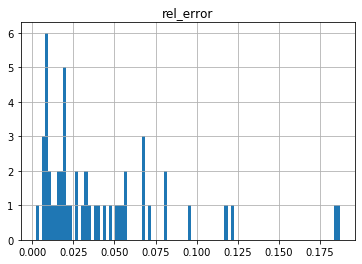

In [56]:
error_state.hist(bins=100)

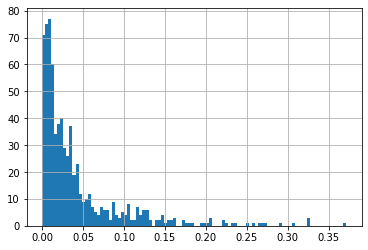

In [57]:
error["rel_error"].hist(bins=100)

Now, the great thing is that literally ALL OF THE ABOVE has been pacakged into a nice function for you, which returns both the trained model and this error dataframe! Simply run the `model_testing` function from the `mdp_model.py` file, and you will get these results!

## Visualization Tools

`plot_pred` allows us to visualize the predicted path of the model compared to the real evolution of the target value.

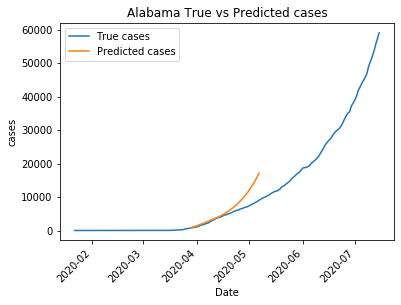

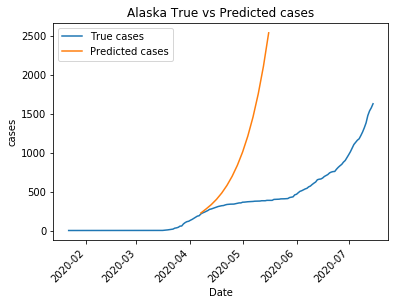

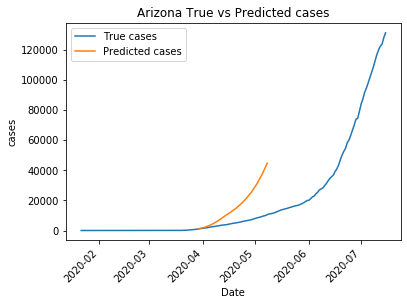

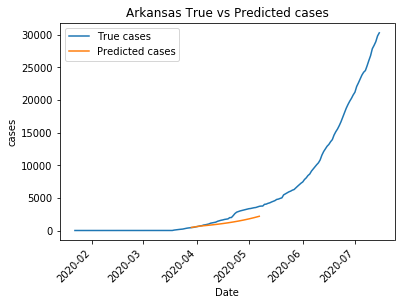

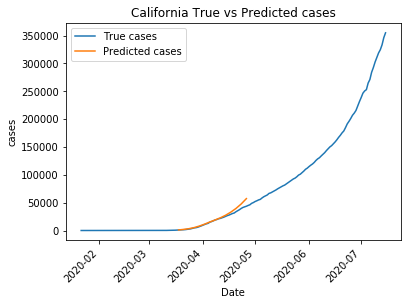

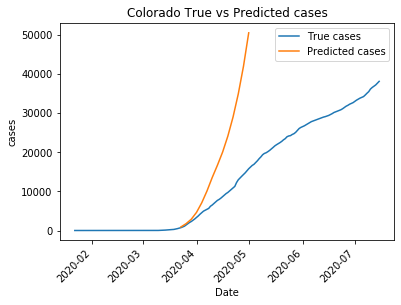

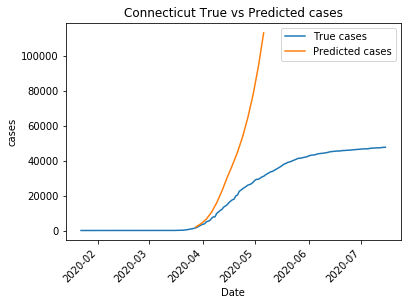

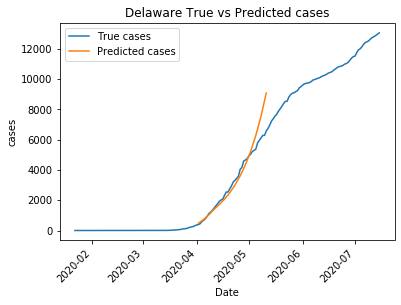

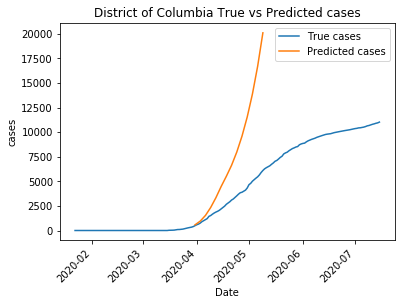

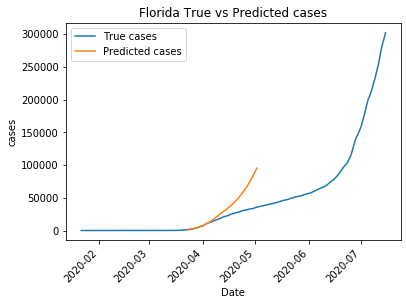

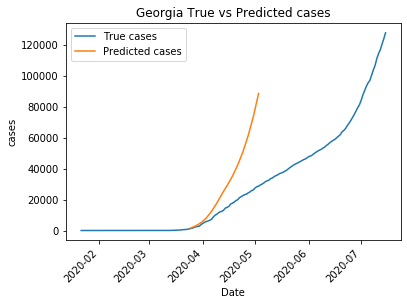

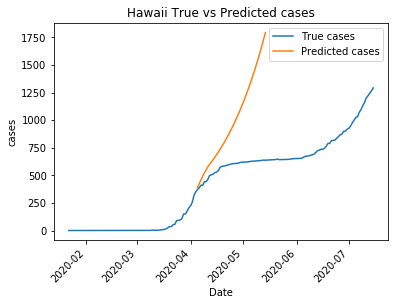

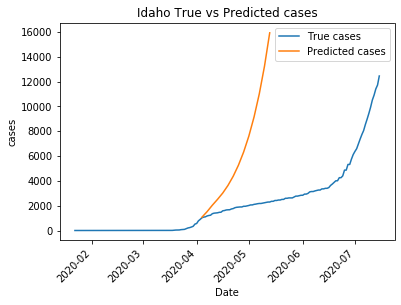

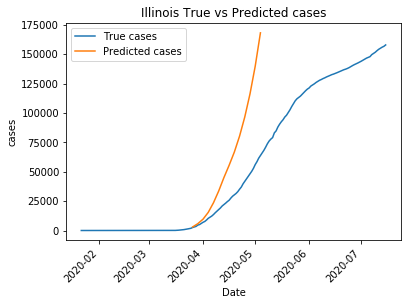

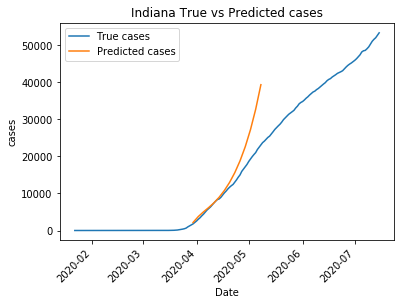

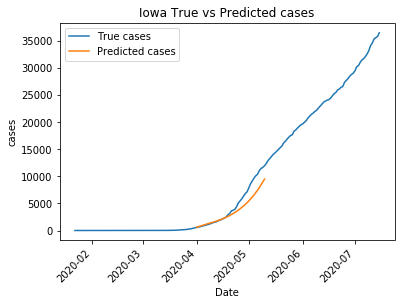

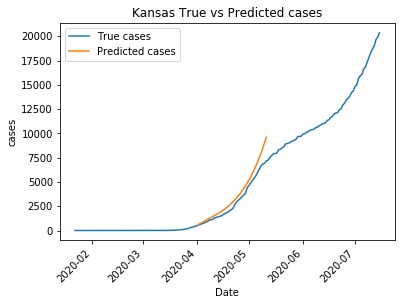

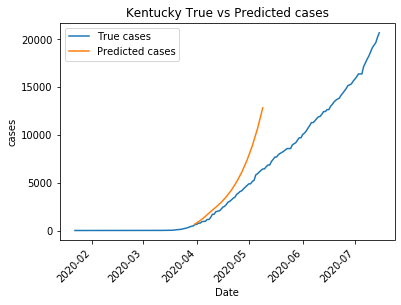

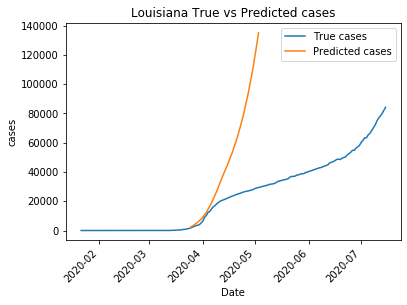

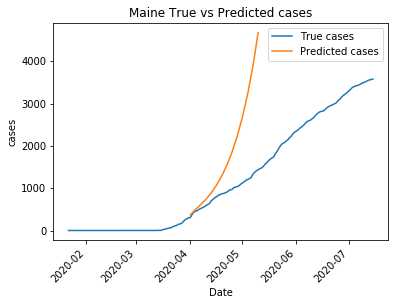

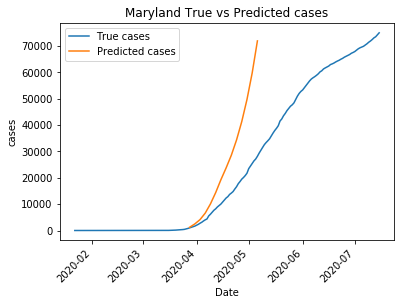

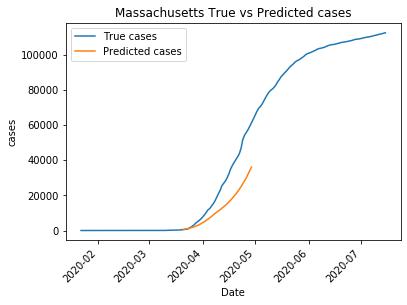

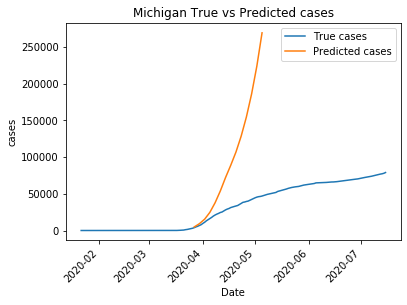

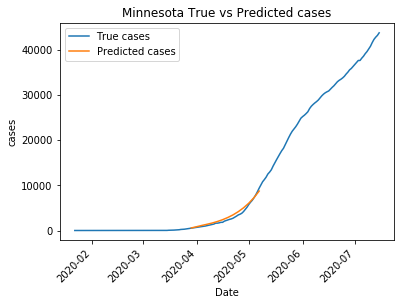

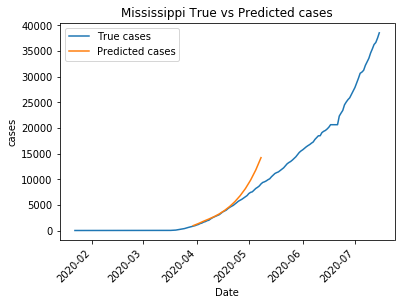

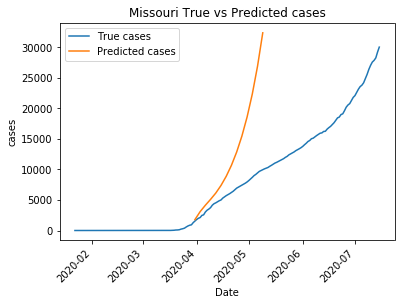

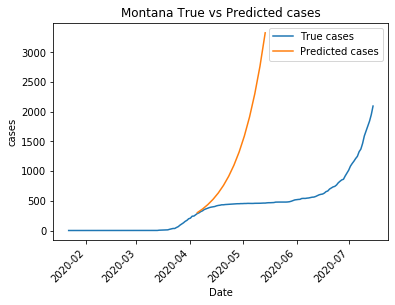

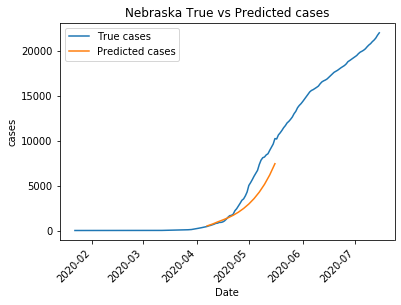

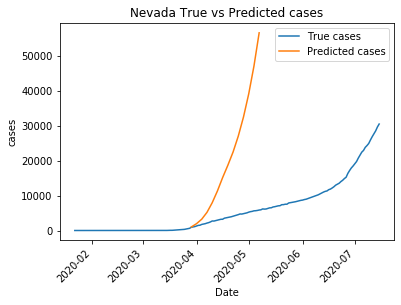

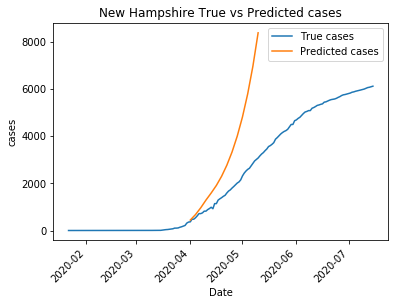

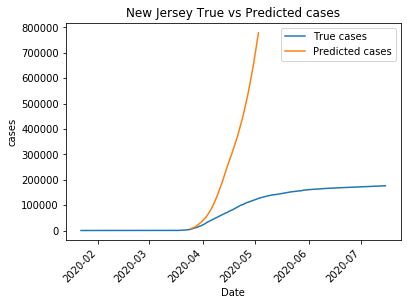

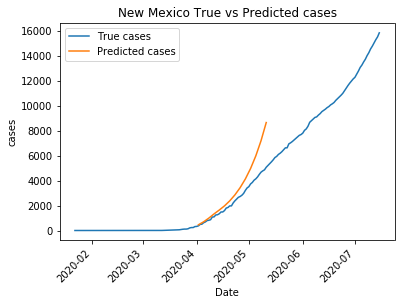

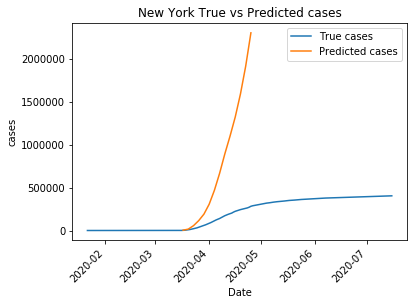

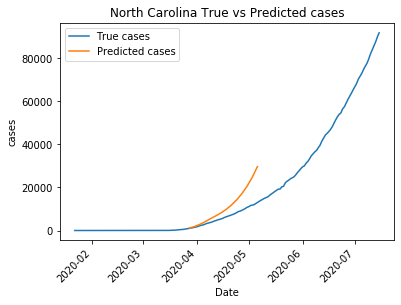

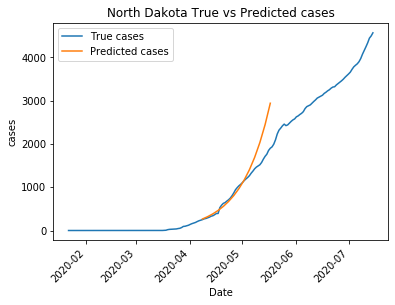

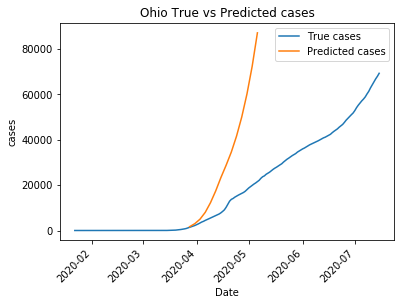

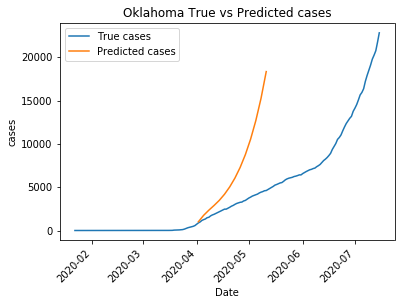

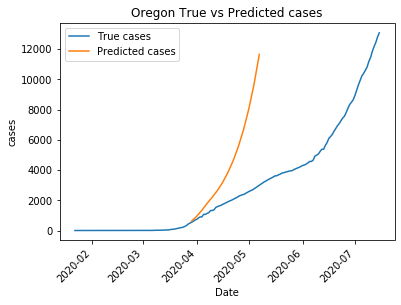

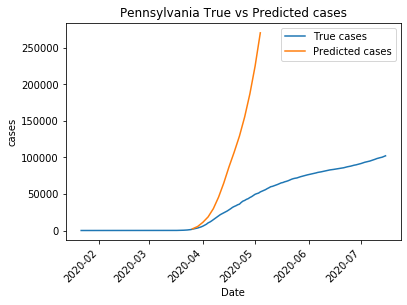

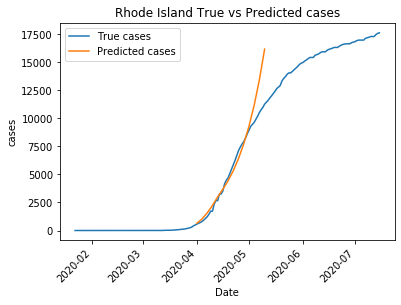

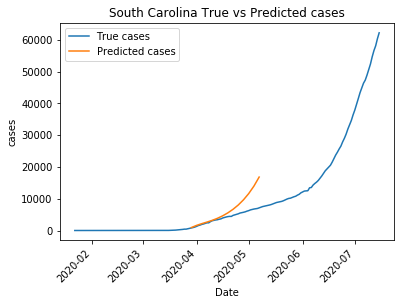

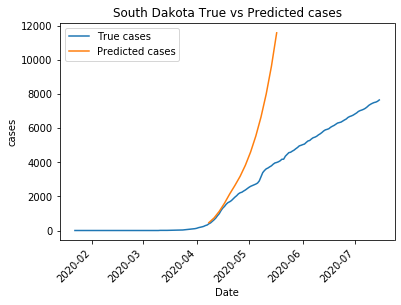

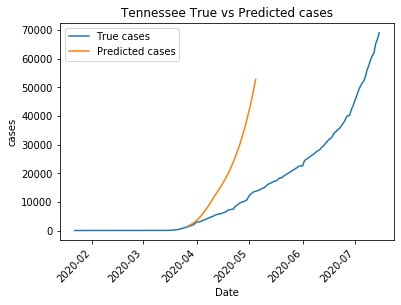

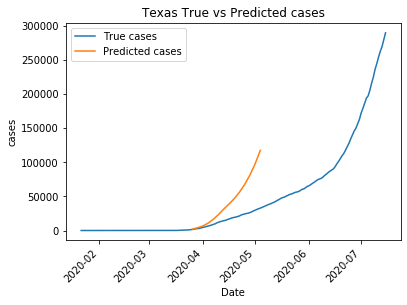

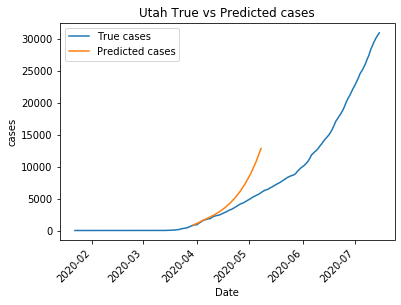

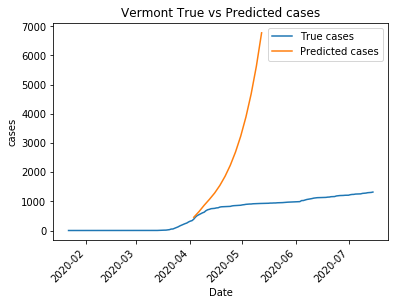

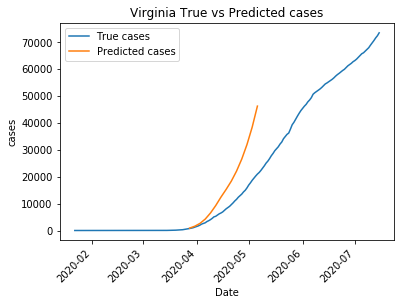

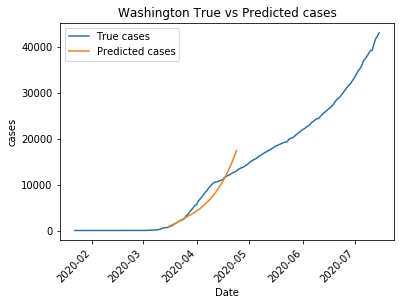

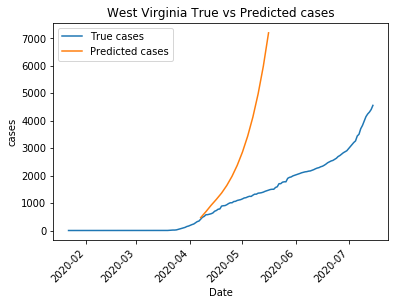

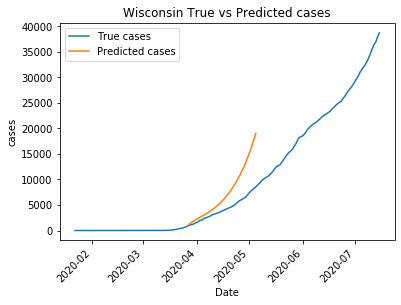

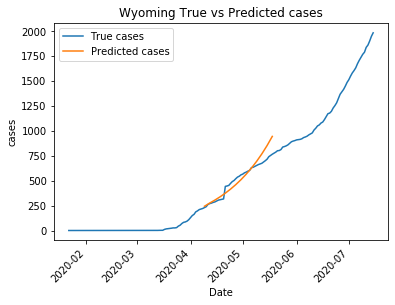

In [58]:
for region in m.df_trained.index:
    plot_pred(m, region, df, 40, from_first=True)

## $\textbf{Grid Search Analysis}$

no model trained currently

In [22]:
with open(os.path.join(MODEL_PATH, "mdp_gs_cases_w_act.pickle"), 'rb') as filehandler:
# with open(os.path.join(MODEL_PATH, "mdp_gs_w_act.pickle"), 'rb') as filehandler:
    mgs = pickle.load(filehandler)

In [91]:
mgs.testing_error

{0: 0.03853768649876888,
 1: 0.042818488980873676,
 2: 0.11816135235342072,
 3: 0.11885557828013076,
 4: 0.6256587780994641,
 5: 0.5659129392650669,
 6: 0.08014052916455346,
 7: 0.06409899270711382,
 8: 0.16934676137921315,
 9: 0.16262009187282658,
 10: 35.23768431612388,
 11: 0.8210913597939423,
 12: 0.08716043811555811,
 13: 0.10292558318369645,
 14: 0.3222282883110434,
 15: 0.3165763597082098,
 16: 3.6667354226844395,
 17: 2.7693856229021034}

In [ ]:
mgs.best_estimator_

In [ ]:
import operator
key_opt = min(mgs.testing_error.items(), key=operator.itemgetter(1))[0]
m_opt = mgs.all_estimators_dict[key_opt]
m_opt

In [ ]:
m_opt.optimal_cluster_size

In [ ]:
# Import full dataset and convert time col to time object
file = '07_08_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])

df_pred = pd.concat([m_opt.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m_opt.region_colname, "TIME"]).join(df.rename(columns={m_opt.date_colname: "TIME"}).set_index([m_opt.region_colname, "TIME"])[m_opt.target_colname], lsuffix="_", rsuffix="").loc[:, [m_opt.target_colname]].reset_index().set_index(m_opt.region_colname)
df_pred.set_index(m_opt.region_colname, inplace=True)
error = mape(df_pred, df_true, m_opt.target_colname).reset_index()
error_state = error.drop("TIME", axis=1).groupby(m_opt.region_colname)["rel_error"].mean().to_frame()
error_state.sort_values("rel_error")

In [ ]:
# computing the out of sample error
error_state.describe()

In [ ]:
error["rel_error"].hist(bins=100)

## $\textbf{Changing in policy analysis}$

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


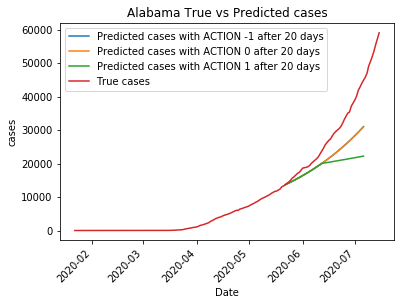

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


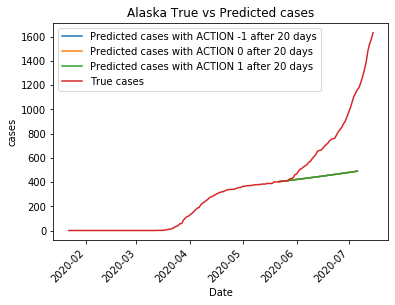

with action -1  STATE bef: 79.0  STATE aft: 79.0
with action 0  STATE bef: 79.0  STATE aft: 29.0
with action 1  STATE bef: 79.0  STATE aft: 12.0


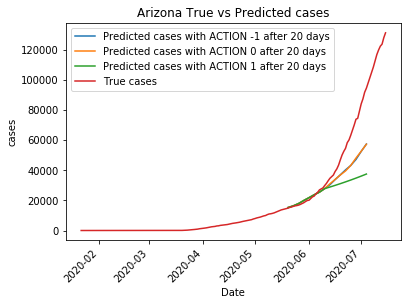

Transition not found: (29.0, -1)
with action 0  STATE bef: 29.0  STATE aft: 67.0
Transition not found: (29.0, 1)


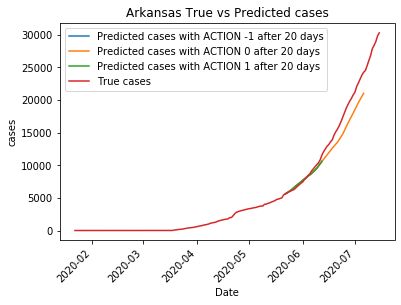

with action -1  STATE bef: 79.0  STATE aft: 79.0
with action 0  STATE bef: 79.0  STATE aft: 29.0
with action 1  STATE bef: 79.0  STATE aft: 12.0


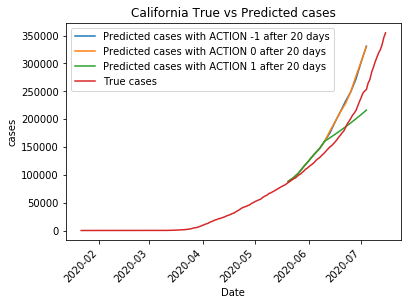

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


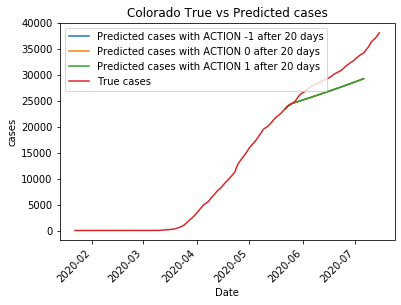

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


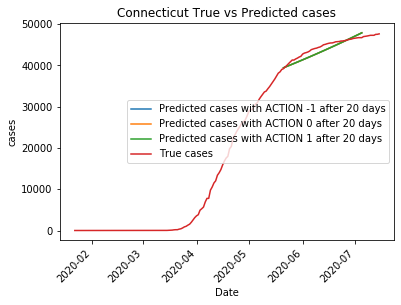

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


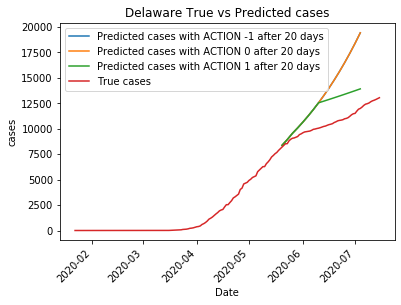

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


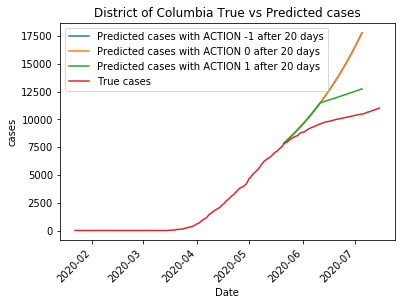

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


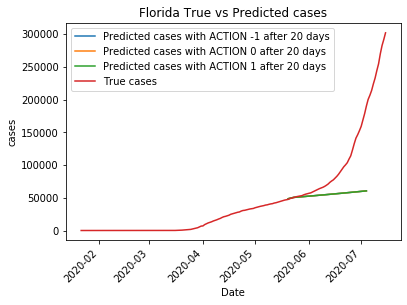

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


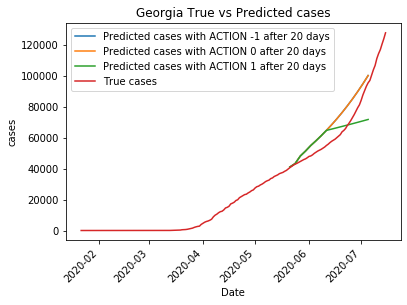

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


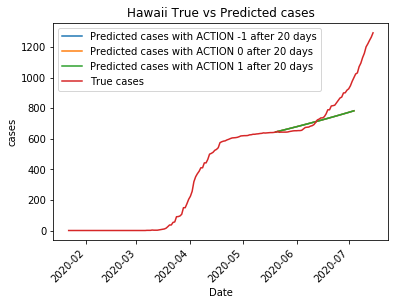

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


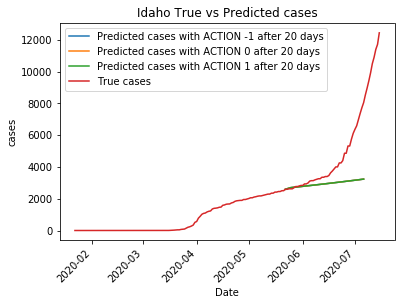

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


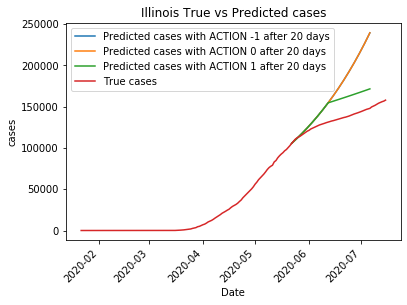

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


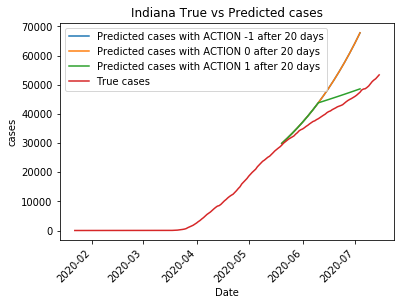

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


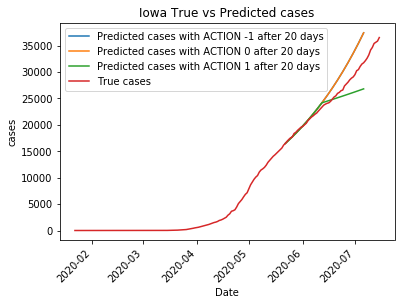

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


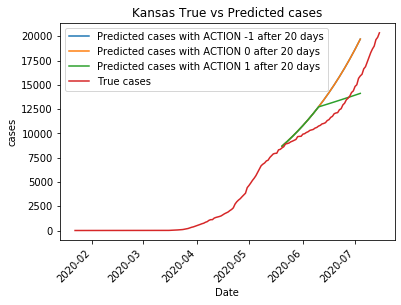

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


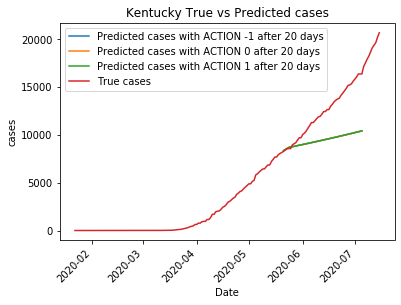

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


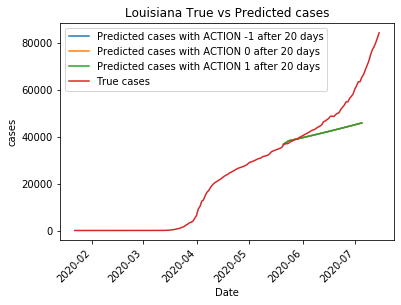

with action -1  STATE bef: 79.0  STATE aft: 79.0
with action 0  STATE bef: 79.0  STATE aft: 29.0
with action 1  STATE bef: 79.0  STATE aft: 12.0


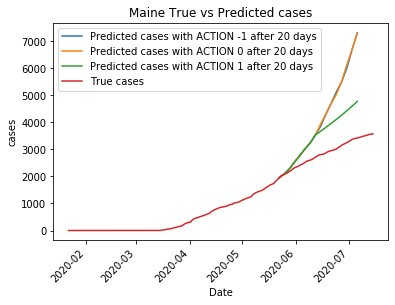

with action -1  STATE bef: 79.0  STATE aft: 79.0
with action 0  STATE bef: 79.0  STATE aft: 29.0
with action 1  STATE bef: 79.0  STATE aft: 12.0


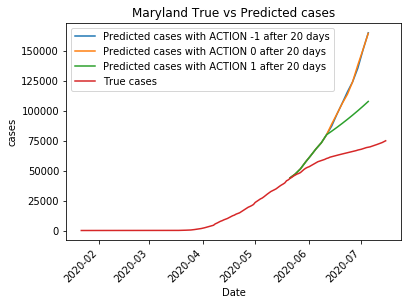

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


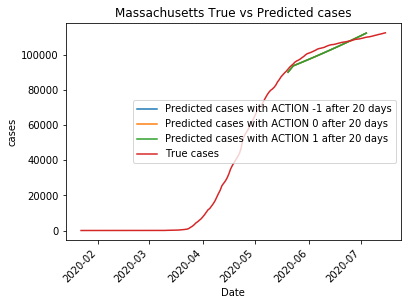

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


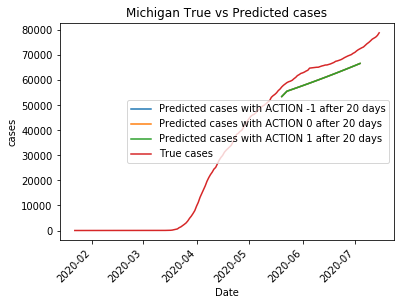

with action -1  STATE bef: 79.0  STATE aft: 79.0
with action 0  STATE bef: 79.0  STATE aft: 29.0
with action 1  STATE bef: 79.0  STATE aft: 12.0


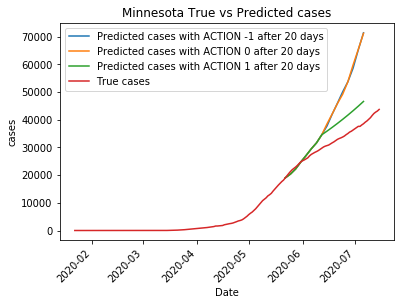

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


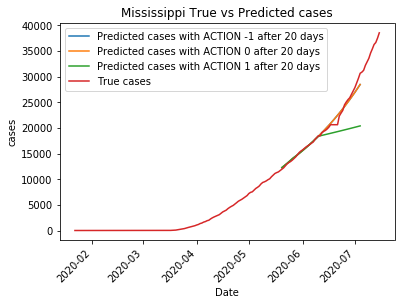

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


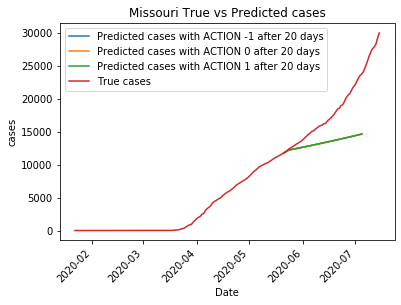

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


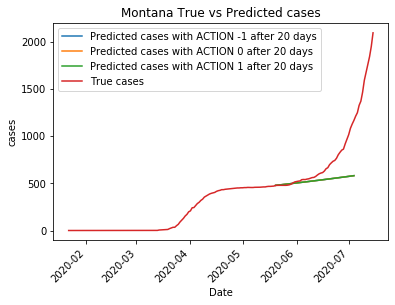

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


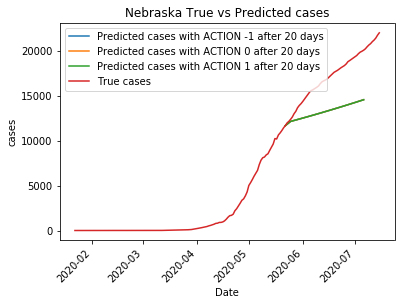

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


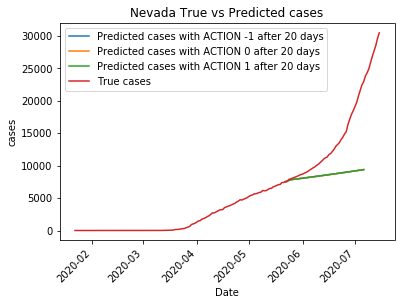

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


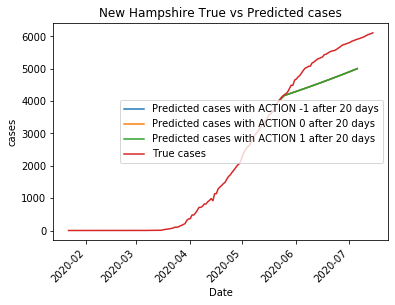

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


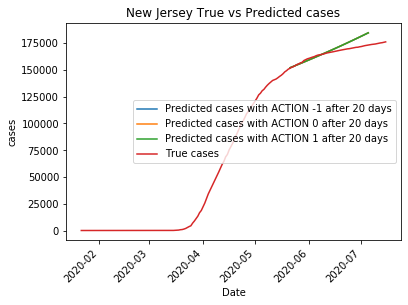

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


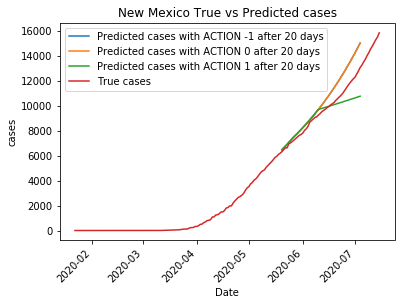

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


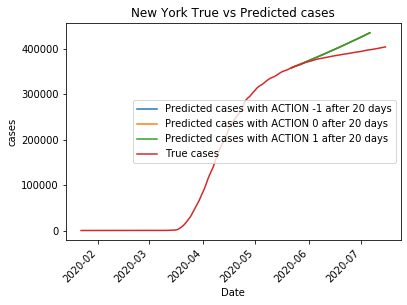

Transition not found: (29.0, -1)
with action 0  STATE bef: 29.0  STATE aft: 67.0
Transition not found: (29.0, 1)


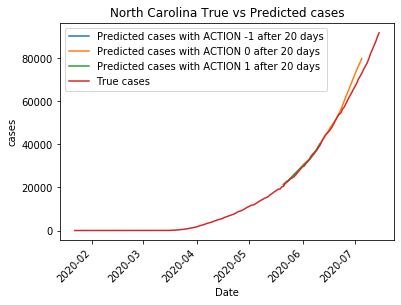

Transition not found: (29.0, -1)
with action 0  STATE bef: 29.0  STATE aft: 67.0
Transition not found: (29.0, 1)


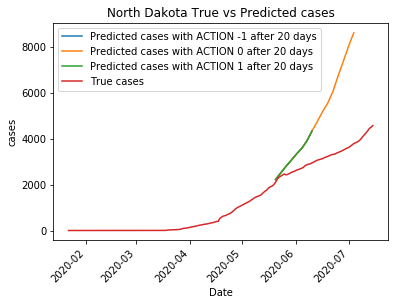

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


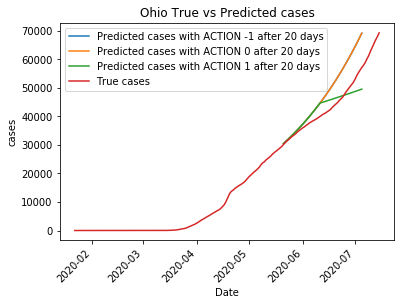

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


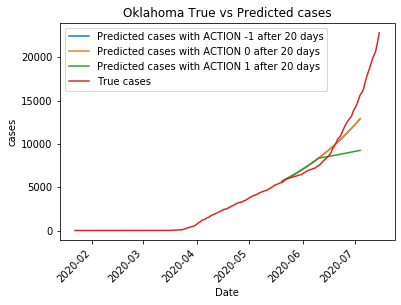

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


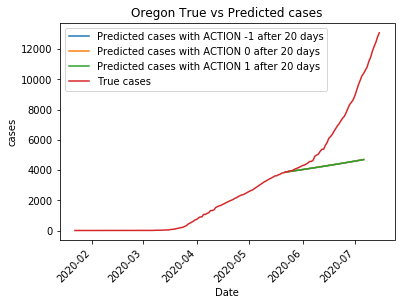

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


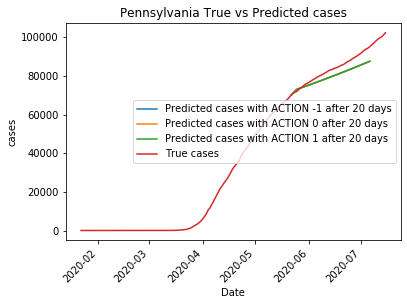

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


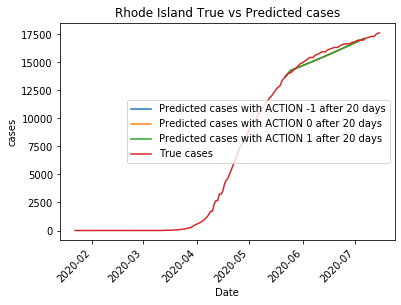

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


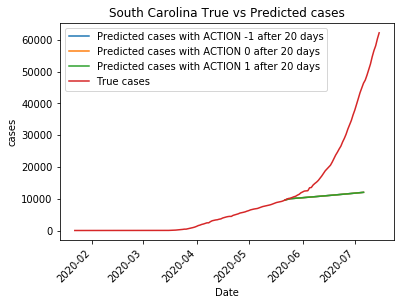

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


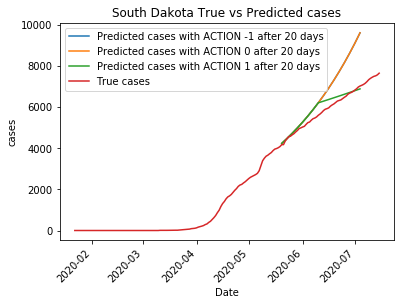

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


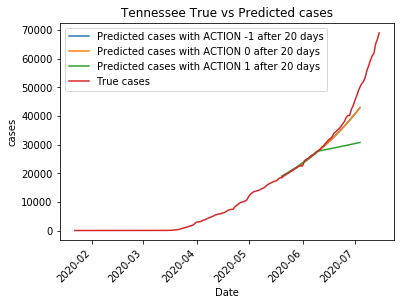

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


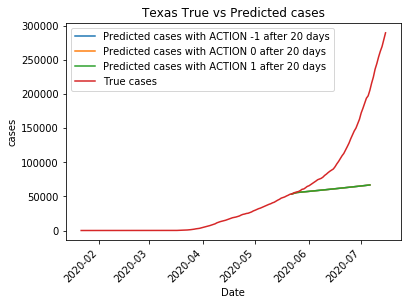

with action -1  STATE bef: 69.0  STATE aft: 69.0
with action 0  STATE bef: 69.0  STATE aft: 69.0
with action 1  STATE bef: 69.0  STATE aft: 19.0


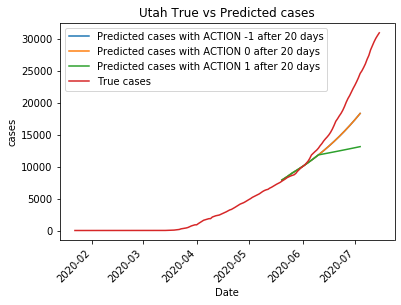

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


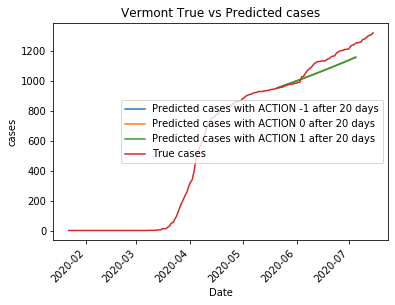

with action -1  STATE bef: 79.0  STATE aft: 79.0
with action 0  STATE bef: 79.0  STATE aft: 29.0
with action 1  STATE bef: 79.0  STATE aft: 12.0


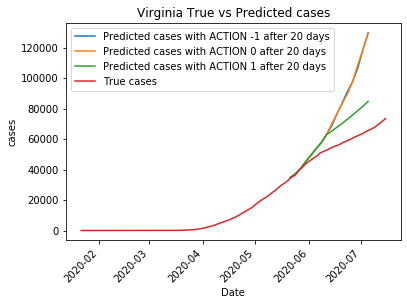

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


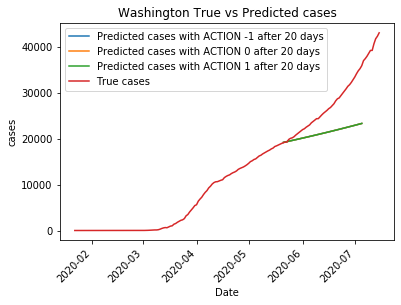

Transition not found: (29.0, -1)
with action 0  STATE bef: 29.0  STATE aft: 67.0
Transition not found: (29.0, 1)


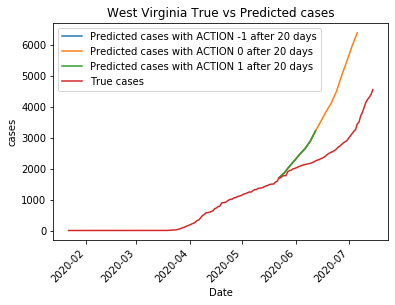

Transition not found: (29.0, -1)
with action 0  STATE bef: 29.0  STATE aft: 67.0
Transition not found: (29.0, 1)


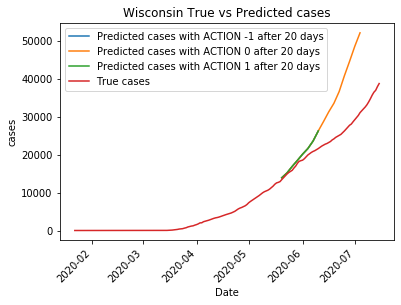

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


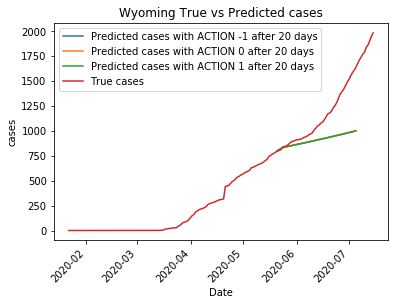

In [23]:
for region in m.df_trained.index:
    plot_pred_action(m, region, df, 45, 20, from_first=False)

with action -1  STATE bef: 30.0  STATE aft: 30.0
with action 0  STATE bef: 30.0  STATE aft: 76.0
Transition not found: (30.0, 1)


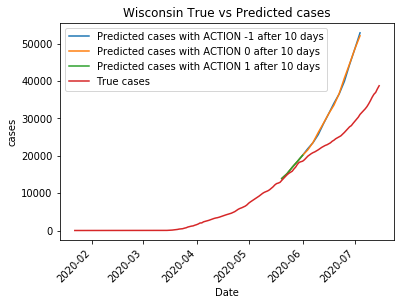

In [24]:
plot_pred_action(m, "Wisconsin", df, 45, 10, from_first=False)

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


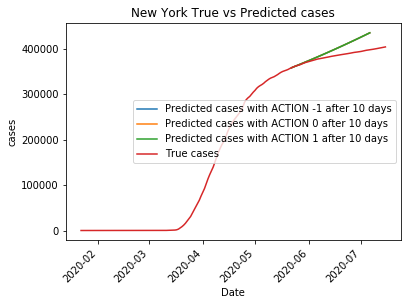

In [25]:
plot_pred_action(m, "New York", df, 45, 10, from_first=False)

## $\textbf{Counterfactual analysis}$

In [10]:
# Setting parameters
file = '05_27_states_combined_v2_w_trend.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file), parse_dates=["date"], index_col = 0)

In [11]:
target_colname = 'cases'
region_colname = 'state'
date_colname = 'date'
feature_cols = ["mobility_score_trend", "cases_pct3", "cases_pct5"]  # action with no features
days_avg = m.days_avg

action_thresh = ([-250, 200], 1)
df_samples, pfeatures = createSamples(df, target_colname, region_colname, date_colname, feature_cols, action_thresh, days_avg)
df_samples.tail()

ID       TIME  mobility_score_trend  cases_pct3  cases_pct5  \
1220  50 2020-05-10           2155.761905    0.038343    0.073080   
1221  50 2020-05-13           1298.714286    0.049283    0.074467   
1222  50 2020-05-16           1319.095238    0.074158    0.112677   
1223  50 2020-05-19           1213.290816    0.045564    0.095708   
1224  50 2020-05-22           1070.178571    0.034794    0.064987   

      mobility_score_trend-1  mobility_score_trend-2  cases_pct3-1  \
1220             3388.761905             4155.476190      0.055509   
1221             2155.761905             3388.761905      0.038343   
1222             1298.714286             2155.761905      0.049283   
1223             1319.095238             1298.714286      0.074158   
1224             1213.290816             1319.095238      0.045564   

      cases_pct3-2  cases_pct5-1  cases_pct5-2       r_t       r_t-1  \
1220      0.057658      0.097111      0.096307  1.038302  644.000000   
1221      0.055509      0.073080      0.097111  1.049352  668.666667   
1222      0.038343      0.074467      0.073080  1.074109  701.666667   
1223      0.049283      0.112677      0.074467  1.045555  753.666667   
1224      0.074158      0.095708      0.112677  1.019036  788.000000   

           r_t-2      RISK  mobility_score_trend_change ACTION    state  \
1220  610.333333  0.037587                  -766.714286     -1  Wyoming   
1221  644.000000  0.048173                 -1233.000000     -1  Wyoming   
1222  668.666667  0.071492                  -857.047619     -1  Wyoming   
1223  701.666667  0.044548                    20.380952      0  Wyoming   
1224  753.666667  0.018857                  -105.804422      0  Wyoming   

           cases  
1220  668.666667  
1221  701.666667  
1222  753.666667  
1223  788.000000  
1224  803.000000

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 80  STATE aft: 24.0


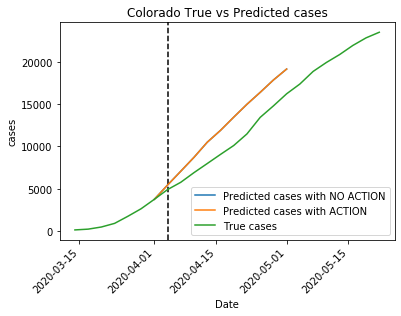

In [51]:
plot_pred_fact(m, "Colorado", df_samples, "20200401", n_days=30)

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 80  STATE aft: 24.0
2020-04-22 00:00:00 : Action 1
Transition not found: (29.0, 1)


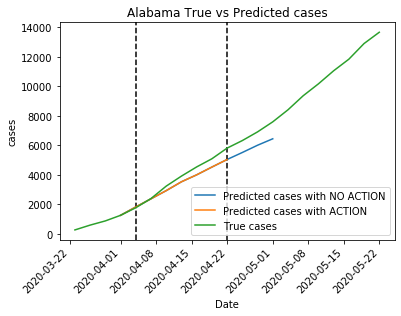

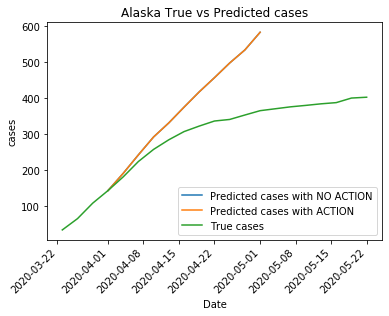

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 80  STATE aft: 24.0
2020-04-25 00:00:00 : Action 1
with action 1  STATE bef: 67.0  STATE aft: 22.0


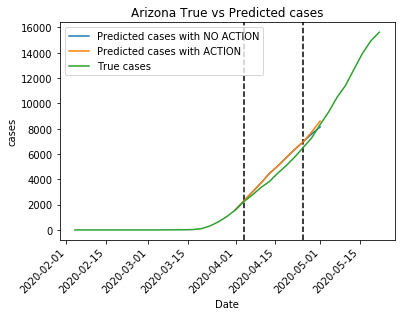

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 71  STATE aft: 39.0
2020-04-22 00:00:00 : Action 1
Transition not found: (29.0, 1)


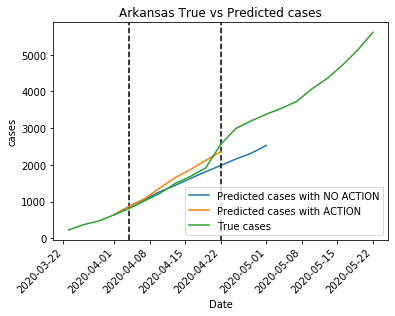

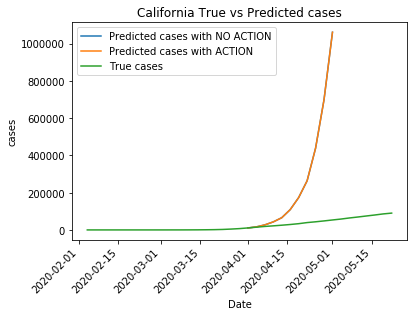

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 80  STATE aft: 24.0


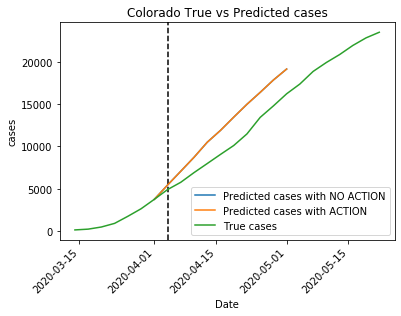

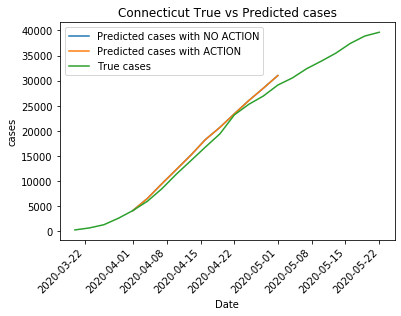

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 80  STATE aft: 24.0


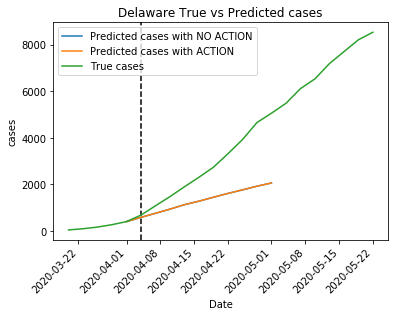

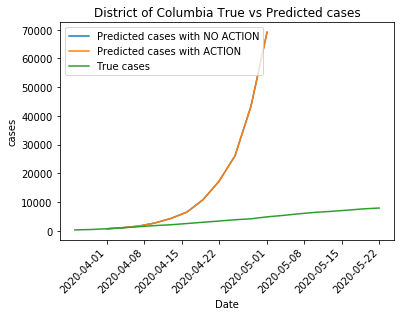

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 80.0  STATE aft: 24.0


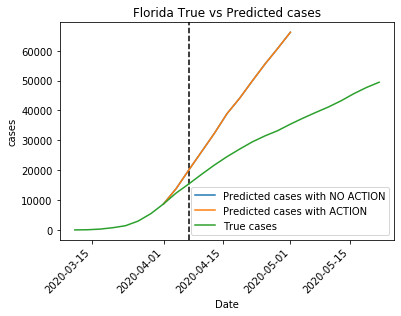

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 82.0  STATE aft: 80.0
2020-04-22 00:00:00 : Action 1
Transition not found: (14.0, 1)


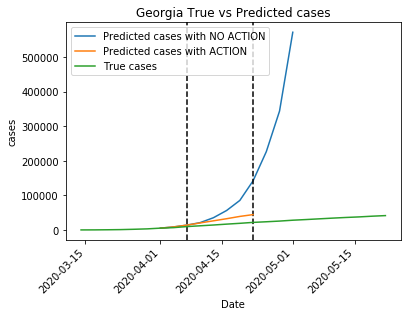

2020-04-22 00:00:00 : Action 1
Transition not found: (74.0, 1)


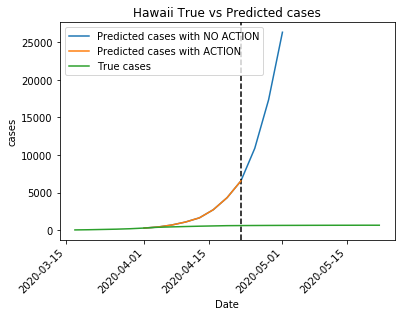

2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 80.0  STATE aft: 24.0
2020-04-19 00:00:00 : Action 1
with action 1  STATE bef: 65.0  STATE aft: 25.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 25.0  STATE aft: 75.0


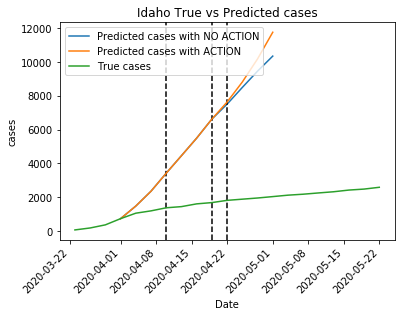

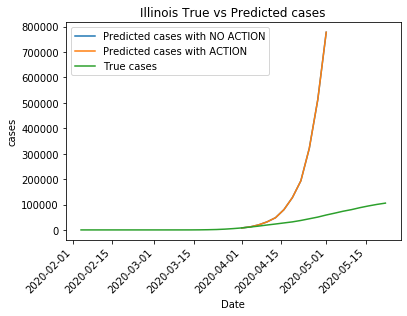

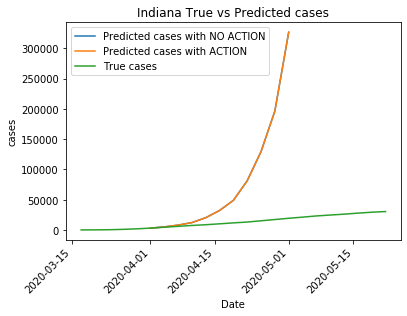

2020-04-22 00:00:00 : Action 1
Transition not found: (29.0, 1)


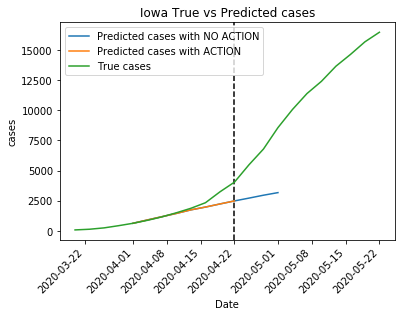

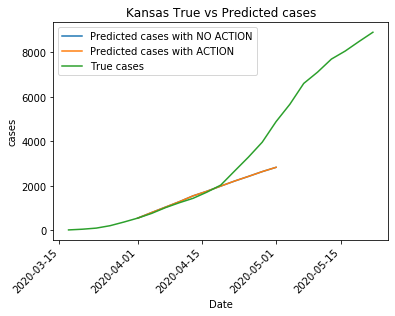

2020-04-19 00:00:00 : Action 1
with action 1  STATE bef: 77.0  STATE aft: 36.0
2020-04-22 00:00:00 : Action 1
Transition not found: (36.0, 1)


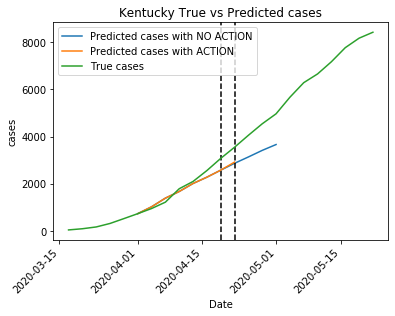

2020-04-22 00:00:00 : Action 1
Transition not found: (14.0, 1)


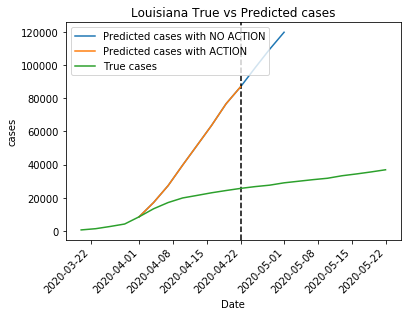

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 81  STATE aft: 59.0
2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 59.0  STATE aft: 77.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 77.0  STATE aft: 75.0
2020-04-19 00:00:00 : Action 1
with action 1  STATE bef: 75.0  STATE aft: 77.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 77.0  STATE aft: 36.0


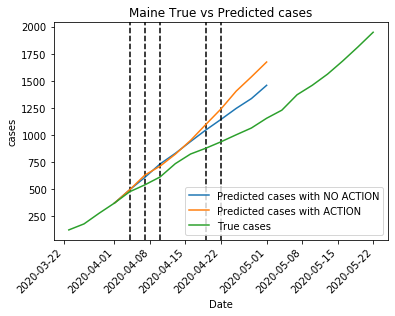

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 4  STATE aft: 0.0
2020-04-07 00:00:00 : Action -1
Transition not found: (0.0, -1)


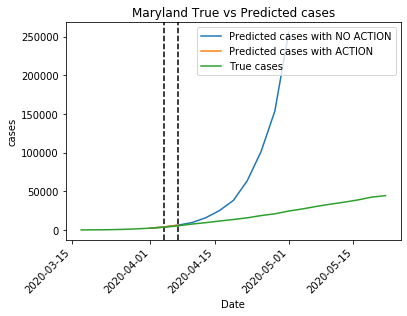

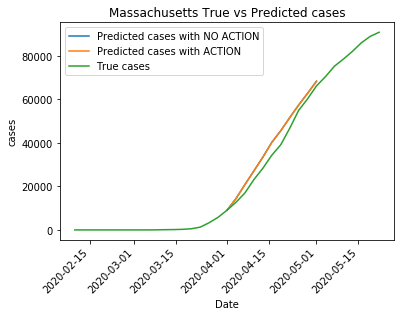

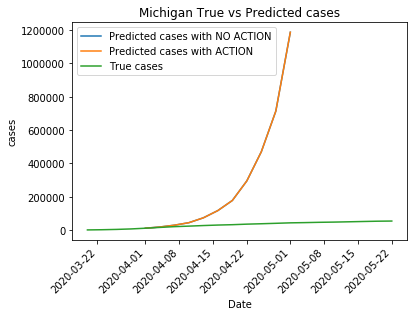

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 24  STATE aft: 78.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 67.0  STATE aft: 22.0


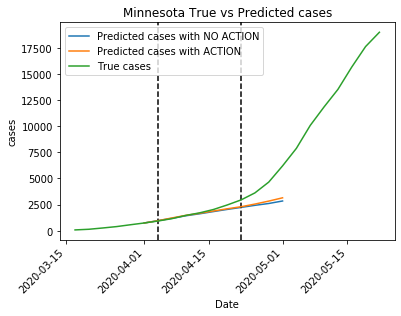

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 71.0  STATE aft: 39.0
2020-04-10 00:00:00 : Action -1
Transition not found: (39.0, -1)


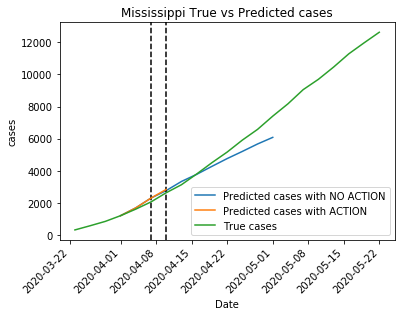

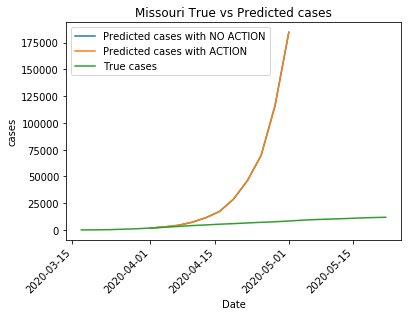

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 81  STATE aft: 59.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 77.0  STATE aft: 36.0


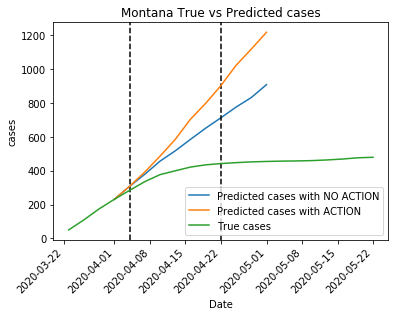

2020-04-22 00:00:00 : Action 1
Transition not found: (29.0, 1)


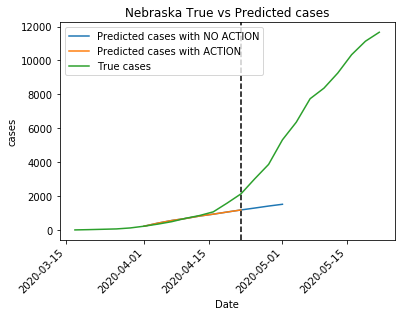

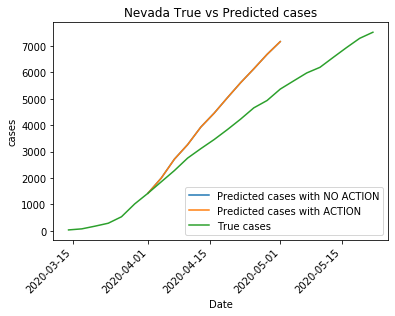

2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 71.0  STATE aft: 39.0


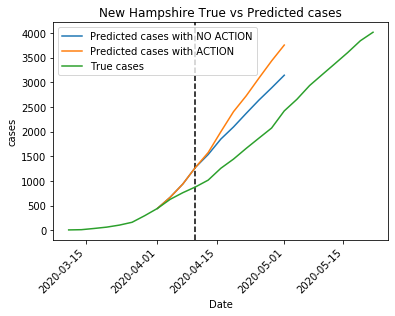

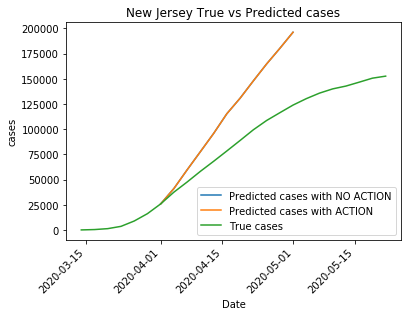

2020-04-22 00:00:00 : Action 1
Transition not found: (74.0, 1)


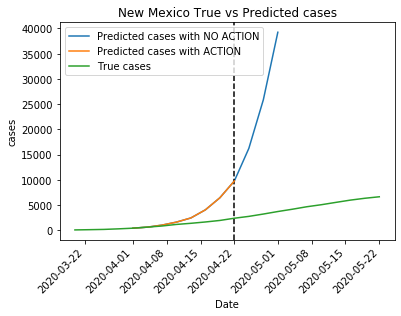

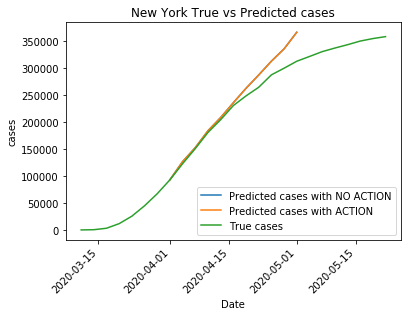

2020-04-04 00:00:00 : Action -1
Transition not found: (1, -1)


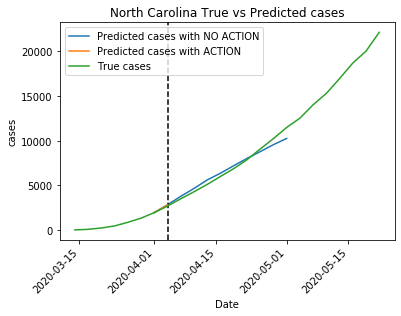

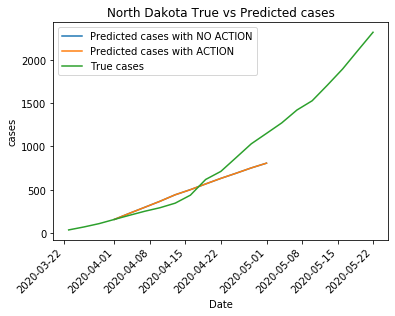

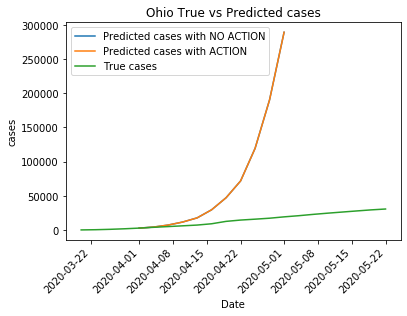

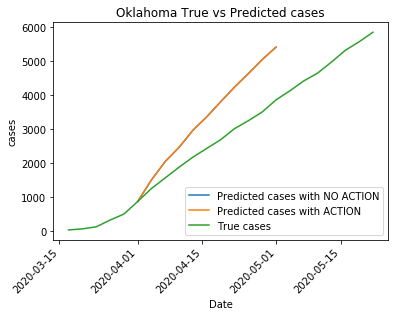

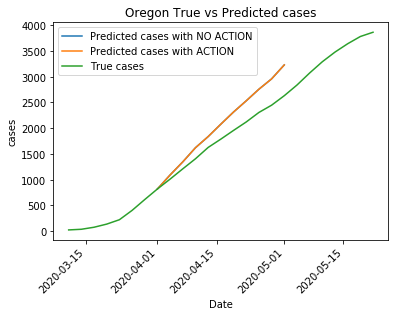

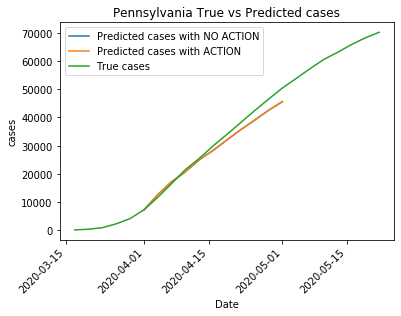

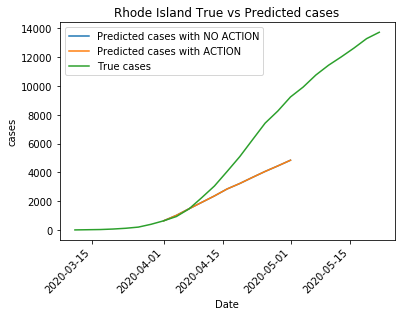

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 4  STATE aft: 0.0
2020-04-07 00:00:00 : Action -1
Transition not found: (0.0, -1)


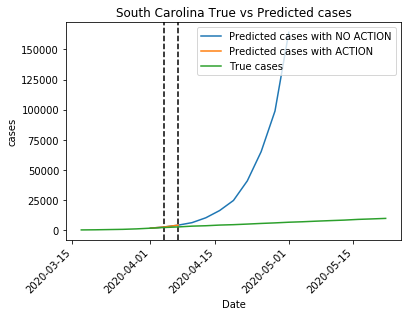

2020-04-22 00:00:00 : Action 1
Transition not found: (82.0, 1)


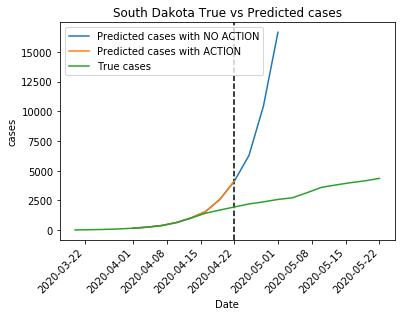

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 26.0  STATE aft: 24.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 24.0  STATE aft: 78.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 77.0  STATE aft: 36.0


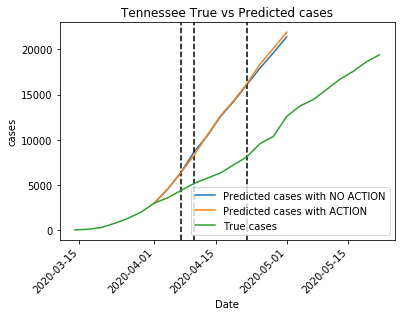

2020-04-28 00:00:00 : Action 1
with action 1  STATE bef: 67.0  STATE aft: 22.0


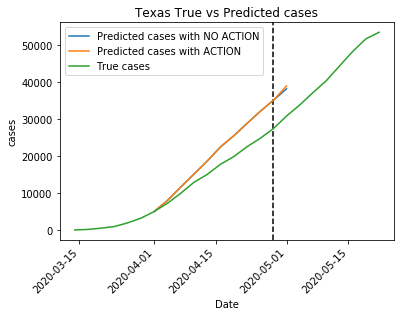

2020-04-28 00:00:00 : Action 1
Transition not found: (76.0, 1)


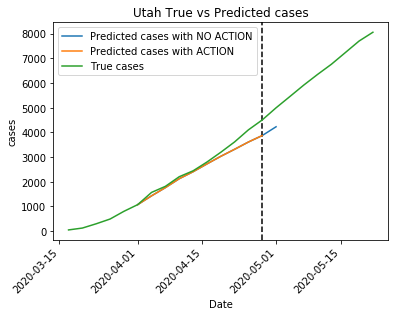

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 81  STATE aft: 59.0
2020-04-10 00:00:00 : Action -1
Transition not found: (51.0, -1)


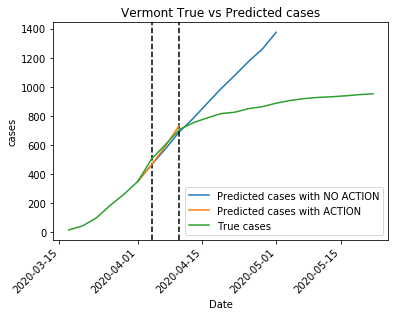

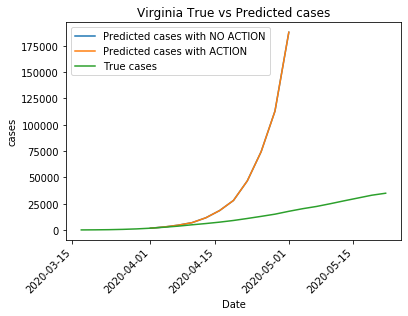

2020-04-04 00:00:00 : Action -1
Transition not found: (15, -1)


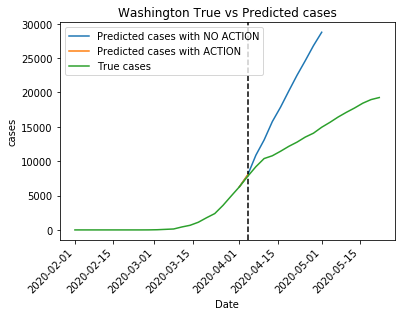

2020-04-19 00:00:00 : Action 1
Transition not found: (82.0, 1)


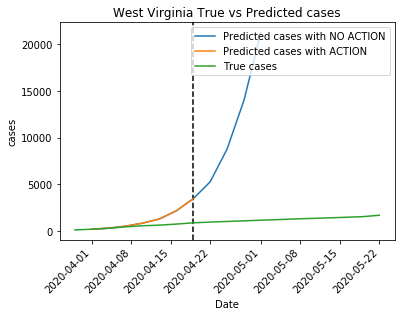

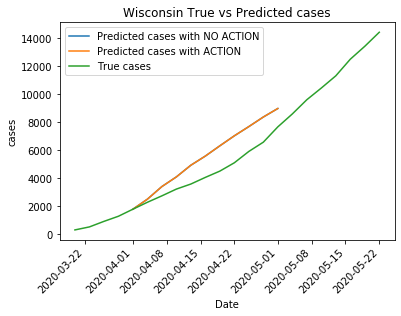

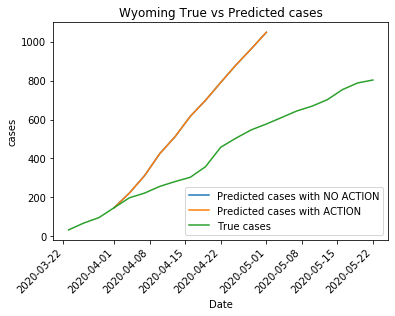

In [52]:
for region in m.df_trained.index:
    plot_pred_fact(m, region, df_samples, "20200401", n_days=30)

In [29]:
m.P_df.shape[0] % 29

10

In [46]:
m.P_df.head(45)

NEXT_CLUSTER
CLUSTER ACTION              
0       -1               1.0
         0               1.0
1       -1              24.0
         0              28.0
         1              28.0
2       -1               5.0
         0               0.0
3       -1               3.0
         0               3.0
         1              22.0
4       -1               0.0
         0               0.0
5       -1               4.0
         0               0.0
6       -1               6.0
         0              13.0
         1               6.0
7       -1              25.0
         0               7.0
         1               7.0
8       -1               1.0
         0              26.0
9       -1              14.0
         0              14.0
         1               3.0
10      -1               0.0
         0               0.0
11      -1               7.0
         0               7.0
12      -1              12.0
         0              12.0
         1               6.0
13      -1              12.0
         0              12.0
         1              13.0
14      -1               3.0
         0              14.0
         1               3.0
15      -1               9.0
         0               9.0
16      -1              11.0
         0              11.0
17       0              20.0
18      -1              18.0
         0              10.0

In [47]:
df_samples[df_samples.state=="Colorado"]

ID       TIME  mobility_score_trend  cases_pct3  cases_pct5  \
137   5 2020-03-14           6635.000000    1.623008    6.106209   
138   5 2020-03-17           6512.619048    0.697214    2.067651   
139   5 2020-03-20           6149.142857    1.109478    1.959382   
140   5 2020-03-23           5823.619048    0.911051    2.204687   
141   5 2020-03-26           5513.380952    0.926539    1.927386   
142   5 2020-03-29           5252.380952    0.521534    1.340524   
143   5 2020-04-01           5108.476190    0.424687    0.846596   
144   5 2020-04-04           4924.857143    0.311923    0.652502   
145   5 2020-04-07           4838.238095    0.176098    0.390005   
146   5 2020-04-10           4851.142857    0.198919    0.330534   
147   5 2020-04-13           4900.000000    0.156047    0.304689   
148   5 2020-04-16           5064.095238    0.135098    0.241087   
149   5 2020-04-19           5240.380952    0.116253    0.217473   
150   5 2020-04-22           5402.428571    0.134959    0.219379   
151   5 2020-04-25           5495.666667    0.171641    0.280062   
152   5 2020-04-28           5517.238095    0.101055    0.217371   
153   5 2020-05-01           5489.476190    0.096989    0.168669   
154   5 2020-05-04           5520.857143    0.071192    0.137252   
155   5 2020-05-07           4614.809524    0.085474    0.136401   
156   5 2020-05-10           2927.285714    0.056267    0.115527   
157   5 2020-05-13           1831.095238    0.046918    0.080215   
158   5 2020-05-16           1860.380952    0.051677    0.086979   
159   5 2020-05-19           1731.273810    0.040982    0.074874   
160   5 2020-05-22           1570.984694    0.044702    0.070608   

     mobility_score_trend-1  mobility_score_trend-2  cases_pct3-1  \
137             6600.190476             6902.809524      3.307190   
138             6635.000000             6600.190476      1.623008   
139             6512.619048             6635.000000      0.697214   
140             6149.142857             6512.619048      1.109478   
141             5823.619048             6149.142857      0.911051   
142             5513.380952             5823.619048      0.926539   
143             5252.380952             5513.380952      0.521534   
144             5108.476190             5252.380952      0.424687   
145             4924.857143             5108.476190      0.311923   
146             4838.238095             4924.857143      0.176098   
147             4851.142857             4838.238095      0.198919   
148             4900.000000             4851.142857      0.156047   
149             5064.095238             4900.000000      0.135098   
150             5240.380952             5064.095238      0.116253   
151             5402.428571             5240.380952      0.134959   
152             5495.666667             5402.428571      0.171641   
153             5517.238095             5495.666667      0.101055   
154             5489.476190             5517.238095      0.096989   
155             5520.857143             5489.476190      0.071192   
156             4614.809524             5520.857143      0.085474   
157             2927.285714             4614.809524      0.056267   
158             1831.095238             2927.285714      0.046918   
159             1860.380952             1831.095238      0.051677   
160             1731.273810             1860.380952      0.040982   

     cases_pct3-2  cases_pct5-1  cases_pct5-2       r_t         r_t-1  \
137      1.541667      5.708333      7.500000  2.484472     53.666667   
138      3.307190      6.106209      5.708333  1.692500    133.333333   
139      1.623008      2.067651      6.106209  2.118168    225.666667   
140      0.697214      1.959382      2.067651  1.898187    478.000000   
141      1.109478      2.204687      1.959382  1.921014    907.333333   
142      0.911051      1.927386      2.204687  1.510996   1743.000000   
143      0.926539      1.340524      1.927386  1.422984   2633.6666

In [38]:
def plot_pred_fact(model, state, df_w_act, starting_date, n_days=30):

    fig, ax = plt.subplots()

    try :
        starting_date = datetime.strptime(starting_date, "%Y%m%d")
    except:
        pass

    df_state = df_w_act[df_w_act[model.region_colname] == state].reset_index().drop("index", axis=1)

    first_date = df_state["TIME"].min()

    starting_n_days = int((starting_date - first_date).days)
    try:
        assert starting_n_days >= 0
    except AssertionError:
        print(" the given starting_date {} occurs before the first date {} of the given data set".format(str(starting_date),
                                                                                                         str(first_date)))
        raise AssertionError

    h = int(np.round(n_days/model.days_avg))
    h_start = int(np.floor(starting_n_days/model.days_avg))

    date = df_state.iloc[h_start]["TIME"]
    target = df_state.iloc[h_start][model.target_colname]

    # predict the current state
    date_features = df_state.iloc[h_start, 2:(2+model.pfeatures)].values.reshape((1, -1))
    s_init = model.classifier.predict(date_features)[0]

    # prediction ACTION = 0
    s = s_init
    dates = [date]
    targets_pred = [target]
    r = 1.
    for i in range(h):
        dates.append(date + timedelta((i+1)*model.days_avg))
        r = r*np.exp(model.R_df.loc[s])
        targets_pred.append(target*r)
        try:
            s = model.P_df.loc[s, 0].values[0]
        except TypeError:
            print("Transition not found:", (s, 0))
            break

    ax.plot(dates, targets_pred, label='Predicted '+model.target_colname+ ' with NO ACTION')

    # prediction with adaptive ACTION
    s = s_init
    dates = [date]
    targets_pred = [target]
    r = 1.
    for i in range(h):
        dates.append(date + timedelta((i+1)*model.days_avg))
        r = r*np.exp(model.R_df.loc[s])
        targets_pred.append(target*r)

        try:
            a = df_state.iloc[(h_start+i)]["ACTION"]
        except:
#             print(state)
#             print("sdays:", starting_n_days)
#             print("current:", starting_n_days+i)
#             print("previous day:", df_state.iloc[(starting_n_days+i-1)])
#             print("dates:", dates)
            break

        if a != 0:
            print("{} : Action {}".format(dates[-1], a))
            ax.axvline(dates[-1], color='k', linestyle='--')
        try:
            s_bf = s
            s = model.P_df.loc[s, a].values[0]
            if a != 0:
                print("with action {}".format(a)," STATE bef:", s_bf, " STATE aft:", s)
        except TypeError:
            print("Transition not found:", (s, a))
            break

    ax.plot(dates, targets_pred, label='Predicted '+model.target_colname+ ' with ACTION')

    ax.plot(df_state["TIME"], \
            df_state[model.target_colname], \
            label = 'True '+model.target_colname)
    ax.set_title('%s True vs Predicted '%state + model.target_colname)
    ax.set_xlabel('Date')
    ax.set_ylabel(model.target_colname)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.show(block=False)
#############################################################################

In [59]:
m.P_df

TRANSITION_CLUSTER
CLUSTER ACTION                    
0       0                      1.0
1       0                      1.0
2       0                      2.0
3       0                      7.0
4       0                      4.0
5       0                      5.0
6       0                     21.0
7       0                     12.0
8       0                     22.0
9       0                      4.0
10      0                      7.0
11      0                      3.0
12      0                      6.0
13      0                     16.0
14      0                      2.0
15      0                     19.0
16      0                      2.0
17      0                     17.0
18      0                     11.0
19      0                      3.0
20      0                      8.0
21      0                      8.0
22      0                      5.0
23      0                     22.0
24      0                     14.0
25      0                      8.0
26      0                      7.0
27      0                      8.0
28      0                     17.0
29      0                     29.0

In [60]:
m.R_df

EST_RISK
CLUSTER          
0        0.050658
1        0.013250
2        0.102683
3        0.716437
4        0.067827
5        0.184799
6        0.423901
7        0.504678
8        0.292464
9        0.084097
10       0.655861
11       0.859762
12       0.471792
13       0.234706
14       0.124484
15       1.547902
16       0.161875
17       0.033695
18       1.026300
19       1.247489
20       0.326349
21       0.353444
22       0.209236
23       0.263794
24       0.142448
25       0.548811
26       0.594195
27       0.380063
28       0.018697
29       0.049792